In [1]:
## Load libraries
library(ggplot2)
library(maps)
library(geosphere)
library (DBI)


library(sparklyr)
library(dplyr)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
## Configure cluster
config <- spark_config()
config$spark.driver.cores   <- 2
config$spark.executor.cores <- 4
config$spark.executor.memory <- "4G"

spark_home <- "/opt/spark/"
spark_version <- "2.7.13"
# sc <- spark_connect(master="yarn-client", version=spark_version, config=config, spark_home=spark_home)
sc <- spark_connect(master="local")


In [3]:
dbSendQuery(sc,"CREATE DATABASE IF NOT EXISTS flights")
tbl_change_db(sc,"flights")


<DBISparkResult>
  SQL  CREATE DATABASE IF NOT EXISTS flights
  ROWS Fetched: 0 [complete]
       Changed: 0

In [4]:
dbSendQuery(sc,"CREATE EXTERNAL TABLE IF NOT EXISTS airports_str (   iata STRING,    airport STRING,    city STRING,    state STRING,    country STRING,    latitude DOUBLE,    longitude DOUBLE) ROW FORMAT  SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' STORED AS TEXTFILE LOCATION '/tmp/airports/' TBLPROPERTIES('skip.header.line.count'='1')")
dbSendQuery(sc,"create table if not exists airports as (select iata, city, state, country, cast(latitude as double), cast (longitude as double) from airports_str)")
dbSendQuery(sc,"CREATE EXTERNAL TABLE IF NOT EXISTS airlines_bi_pq ( year INT, month INT, day INT, dayofweek INT, dep_time INT, crs_dep_time INT, arr_time INT, crs_arr_time INT, carrier STRING, flight_num INT, tail_num INT, actual_elapsed_time INT, crs_elapsed_time INT, airtime INT, arrdelay INT, depdelay INT, origin STRING, dest STRING, distance INT, taxi_in INT, taxi_out INT, cancelled INT, cancellation_code STRING, diverted INT, carrier_delay INT, weather_delay INT, nas_delay INT, security_delay INT, late_aircraft_delay INT, date_yyyymm STRING) STORED AS PARQUET LOCATION '/tmp/airlines'")


<DBISparkResult>
  SQL  CREATE EXTERNAL TABLE IF NOT EXISTS airports_str (   iata STRING,    airport STRING,    city STRING,    state STRING,    country STRING,    latitude DOUBLE,    longitude DOUBLE) ROW FORMAT  SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' STORED AS TEXTFILE LOCATION '/tmp/airports/' TBLPROPERTIES('skip.header.line.count'='1')
  ROWS Fetched: 0 [complete]
       Changed: 0

ERROR: Error: org.apache.spark.sql.AnalysisException: Can not create the managed table('`flights`.`airports`'). The associated location('file:/home/gregorygrubbs/projects/datascience/CDSW-Demos-gg/flight-analytics/notebooks/jupyter/spark-warehouse/flights.db/airports') already exists.;
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.validateTableLocation(SessionCatalog.scala:331)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.createTable(SessionCatalog.scala:317)
	at org.apache.spark.sql.hive.execution.CreateHiveTableAsSelectCommand.run(CreateHiveTableAsSelectCommand.scala:72)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:115)
	at org.apache.spark.sql.Dataset$$anonfun$6.apply(Dataset.scala:195)
	at org.apache.spark.sql.Dataset$$anonfun$6.apply(Dataset.scala:195)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:195)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:80)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:642)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at sparklyr.Invoke.invoke(invoke.scala:139)
	at sparklyr.StreamHandler.handleMethodCall(stream.scala:123)
	at sparklyr.StreamHandler.read(stream.scala:66)
	at sparklyr.BackendHandler.channelRead0(handler.scala:51)
	at sparklyr.BackendHandler.channelRead0(handler.scala:4)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:105)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:348)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:340)
	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:348)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:340)
	at io.netty.handler.codec.ByteToMessageDecoder.fireChannelRead(ByteToMessageDecoder.java:310)
	at io.netty.handler.codec.ByteToMessageDecoder.channelRead(ByteToMessageDecoder.java:284)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:348)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:340)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1359)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:348)
	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:935)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:138)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:497)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:459)
	at io.netty.util.concurrent.SingleThreadEventExecutor$5.run(SingleThreadEventExecutor.java:858)
	at io.netty.util.concurrent.DefaultThreadFactory$DefaultRunnableDecorator.run(DefaultThreadFactory.java:138)
	at java.lang.Thread.run(Thread.java:748)



In [6]:
airlines <- tbl(sc, "airlines_bi_pq")
airlines


ERROR: Error: org.apache.spark.sql.AnalysisException: Table or view not found: airlines_bi_pq; line 2 pos 5
	at org.apache.spark.sql.catalyst.analysis.package$AnalysisErrorAt.failAnalysis(package.scala:47)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.org$apache$spark$sql$catalyst$analysis$Analyzer$ResolveRelations$$lookupTableFromCatalog(Analyzer.scala:733)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.resolveRelation(Analyzer.scala:685)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$8.applyOrElse(Analyzer.scala:715)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$8.applyOrElse(Analyzer.scala:708)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$apply$1.apply(AnalysisHelper.scala:90)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$apply$1.apply(AnalysisHelper.scala:90)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:89)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:194)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperatorsUp(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:326)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:324)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:194)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperatorsUp(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:326)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:324)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:194)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperatorsUp(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1$$anonfun$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:326)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:324)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:87)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$$anonfun$resolveOperatorsUp$1.apply(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:194)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$class.resolveOperatorsUp(AnalysisHelper.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:708)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:654)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:87)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:84)
	at scala.collection.LinearSeqOptimized$class.foldLeft(LinearSeqOptimized.scala:124)
	at scala.collection.immutable.List.foldLeft(List.scala:84)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:84)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:76)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:76)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:127)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:121)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$$anonfun$executeAndCheck$1.apply(Analyzer.scala:106)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$$anonfun$executeAndCheck$1.apply(Analyzer.scala:105)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:201)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:105)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:57)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:55)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:47)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:79)
	at org.apache.spark.sql.SparkSession.sql(SparkSession.scala:642)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at sparklyr.Invoke.invoke(invoke.scala:139)
	at sparklyr.StreamHandler.handleMethodCall(stream.scala:123)
	at sparklyr.StreamHandler.read(stream.scala:66)
	at sparklyr.BackendHandler.channelRead0(handler.scala:51)
	at sparklyr.BackendHandler.channelRead0(handler.scala:4)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:105)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:348)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:340)
	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:362)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChanne


In [5]:
airline_counts_by_year <- airlines %>% group_by(year) %>% summarise(count=n()) %>% collect
airline_counts_by_year %>% tbl_df %>% print(n=nrow(.))


ERROR: Error in eval(expr, envir, enclos): object 'airlines' not found


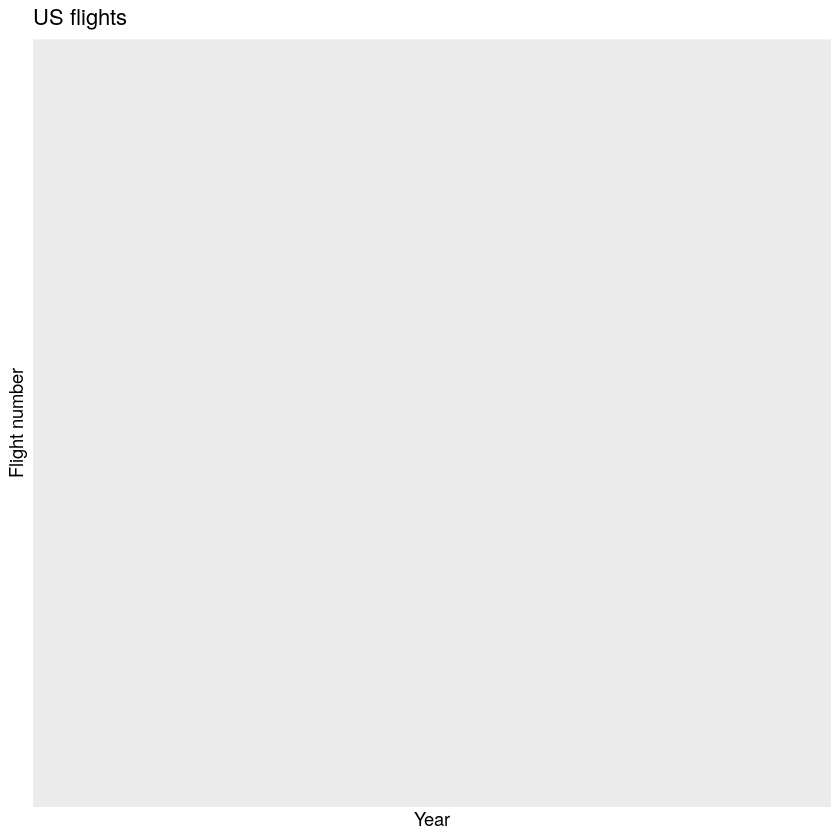

In [28]:
g <- ggplot(airline_counts_by_year, aes(x=year, y=count))
g <- g + geom_line(
  colour = "magenta",
  linetype = 1,
  size = 0.8
)
g <- g + xlab("Year")
g <- g + ylab("Flight number")
g <- g + ggtitle("US flights")
plot(g)
